# Project 3 - Justin Kaufman



Since we don't expect you to learn an entirely new approach to predictive modeling for this project, we instead encourage you to work with the models you already are familiar with in Project 1. 

For this project the easiest approach will simply be to condense the time series data into new features (e.g., engineer a feature for last month's sales, rolling averages, etc.) which would then allow you to treat each row as it's own independent data point. 

You can then simply use this month's sales data as the label, drop it from your dataframe and run a regression on it. 

This is certainly not the only approach you can take, and we highly encourage you experimenting with alternatives. But if you're stuck, this will give you a framework for getting started.

In [357]:
# import libraries 
import numpy as np 
import pandas as pd  
import seaborn as sns
import matplotlib.pyplot as plt

Let's first import our data.

In [358]:
# import the data 
dataunits = pd.read_csv('data/BrandTotalUnits.csv')
datasales = pd.read_csv('data/BrandTotalSales.csv')
branddetails = pd.read_csv('data/BrandDetails.csv')
price = pd.read_csv('data/BrandAverageRetailPrice.csv')
datasales.head(20)

,Months,Brand,Total Sales ($)
0,09/2018,10x Infused,"1,711.334232"
1,09/2018,1964 Supply Co.,"25,475.21594500000"
2,09/2018,3 Bros Grow,"120,153.644757"
3,09/2018,3 Leaf,"6,063.5297850000000"
4,09/2018,350 Fire,"631,510.0481550000"
5,09/2018,710 Labs,"2,065,970.9803990000"
6,09/2018,A&A Craft Inc,"5,094.305340000000"
7,09/2018,AA Packaging,"2,333.3399880000000"
8,09/2018,Absolute Xtracts,"5,747,227.563172000"
9,09/2018,Aces Extracts,"155,523.768684"


In [359]:
datasales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25279 entries, 0 to 25278
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Months           25279 non-null  object
 1   Brand            25279 non-null  object
 2   Total Sales ($)  25279 non-null  object
dtypes: object(3)
memory usage: 592.6+ KB


So first issue is the data in its current form isn't really useful to us, so let's do some conversion of our data.

In [360]:
#First convert our months to datetime
dataunits['Months'] = pd.to_datetime(dataunits['Months'])
#Total units is too large currently to convert to a float
#need to trim it first, remove non-numeric characters then convert to float
dataunits['Total Units'] = dataunits['Total Units'].str[:8]
dataunits['Total Units'] = dataunits['Total Units'].str.replace(',', '').astype(float)

dataunits['Total Units'] = pd.to_numeric(dataunits['Total Units'])


dataunits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27686 entries, 0 to 27685
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Brands            27686 non-null  object        
 1   Months            27686 non-null  datetime64[ns]
 2   Total Units       25712 non-null  float64       
 3   vs. Prior Period  24935 non-null  float64       
dtypes: datetime64[ns](1), float64(2), object(1)
memory usage: 865.3+ KB


In [361]:
#First convert our months to datetime
datasales['Months'] = pd.to_datetime(datasales['Months'])
#Total units is too large currently to convert to a float
#need to trim it first then convert to float
datasales['Total Sales ($)'] = datasales['Total Sales ($)'].str[:8]
datasales['Total Sales ($)'] = datasales['Total Sales ($)'].str.replace(',', '')
datasales['Total Sales ($)'] = pd.to_numeric(datasales['Total Sales ($)'])


datasales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25279 entries, 0 to 25278
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Months           25279 non-null  datetime64[ns]
 1   Brand            25279 non-null  object        
 2   Total Sales ($)  25279 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 592.6+ KB


## TimeSeries Feature Engineering + Main Data Frame

So there's a number of ways of approaching this but given the complexity of multiple brands with overlapping time intervals what seems to work easiest for me is breaking the dataset up by brand, engineering the features you want for each brand, and then reassembling the new dataframe. 

In [362]:
price['Months'] = pd.to_datetime(price['Months'])

In [363]:
brands = dataunits["Brands"].unique()
brands

array(['#BlackSeries', '101 Cannabis Co.', '10x Infused', ..., 'Zlixir',
       'Zoma', 'Zuma Topicals'], dtype=object)

We'll now create two features based on sales history. I'm going to take last month's sales, as well as a rolling average of sales for the last three months.

So now I have a dataframe with merged features and engineered features. I now want to read in some brand specific features to augment my dataset. 

I have a theory that it's important to determine if a company offers inhaleable and edible products as part of their product inventory so I'm going to create binary categorical features.

I also believe that a total count of the number of products the brand offers is also a useful feature to include. Fortunately that's easy enough to determine!

In [364]:
df=pd.DataFrame()

for brand in brands:
    units = dataunits[dataunits.Brands == brand]
    
    # creating new dataframe from consumption column
    #data_historic = units[['Total Units']]
    # inserting new column with yesterday's consumption values
    units.loc[:,'Previous Month'] = units.loc[:,'Total Units'].shift(1)
    # inserting another column with difference between yesterday and day before yesterday's consumption values.

    units.loc[:,'Rolling Average'] = (units.loc[:,'Total Units'].shift(1) + units.loc[:,'Total Units'].shift(2) + units.loc[:,'Total Units'].shift(3))/3
    
    
    sales = datasales[datasales.Brand == brand]
    
    units = units.merge(sales, left_on='Months', right_on='Months')
    
    units = units.drop(['Brand'], 1)
    
    branddetails2 = branddetails[branddetails.Brand == brand]
    
    value = 0
    value1 = 0

    if 'Inhaleables' in branddetails2['Category L1'].values:
        value = 1
    if 'Edibles' in branddetails2['Category L1'].values:
        value1 = 1

    units['Inhaleables'] = value
    units['Edible'] = value1
    
    
    
    
    productcount = (branddetails2.Brand == brand).count()
    
    units['ProdCount'] = productcount
    
    
    avg_retail = price[price.Brands == brand]
    avg_retail=avg_retail.drop(columns=['Brands','vs. Prior Period'])
    
    
    units = units.merge(avg_retail, left_on='Months', right_on='Months')
    
    

    
    df=df.append(units)
    
#once you've successfully completed your feature engineering for 
#a single brand you can try wrapping it in a for loop to engineer 
#all brand features

/opt/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/var/folders/d0/r5_rt10j15j98xny820n56kw0000gp/T/ipykernel_2658/462134128.py:19: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  units = units.drop(['Brand'], 1)


In [365]:
df.head(10)

,Brands,Months,Total Units,vs. Prior Period,Previous Month,Rolling Average,Total Sales ($),Inhaleables,Edible,ProdCount,ARP
0,#BlackSeries,2020-08-01,1616.3300,NaN,NaN,NaN,25352.10,1,0,4,15.684913
1,#BlackSeries,2021-01-01,715.5328,NaN,NaN,NaN,9739.42,1,0,4,13.611428
2,#BlackSeries,2021-02-01,766.6691,0.071466,715.5328,NaN,9102.80,1,0,4,11.873182
0,101 Cannabis Co.,2019-11-01,131.0677,NaN,NaN,NaN,4465.04,1,0,77,34.066667
1,101 Cannabis Co.,2020-01-01,345.4134,NaN,NaN,NaN,11790.60,1,0,77,34.134929
2,101 Cannabis Co.,2020-02-01,696.6584,1.016883,345.4134,NaN,20266.70,1,0,77,29.091388
3,101 Cannabis Co.,2020-03-01,943.3933,0.354169,696.6584,NaN,30465.40,1,0,77,32.293498
4,101 Cannabis Co.,2020-04-01,712.4981,-0.244750,943.3933,661.821700,23465.60,1,0,77,32.934344
5,101 Cannabis Co.,2020-05-01,619.8410,-0.130045,712.4981,784.183267,21348.30,1,0,77,34.441725
6,101 Cannabis Co.,2020-06-01,426.1504,-0.312484,619.8410,758.577467,14111.70,1,0,77,33.114497


Imputation:

In [366]:
len(df.Brands)

25279

In [367]:
df.isna().sum()

Brands                 0
Months                 0
Total Units            0
vs. Prior Period    2318
Previous Month      2318
Rolling Average     6179
Total Sales ($)        0
Inhaleables            0
Edible                 0
ProdCount              0
ARP                    0
dtype: int64

Get rid of na rows for all columns with NA because there are so many 

In [368]:
df.dropna(inplace=True)
len(df.Brands)

19100

In [369]:
df.head(10)

,Brands,Months,Total Units,vs. Prior Period,Previous Month,Rolling Average,Total Sales ($),Inhaleables,Edible,ProdCount,ARP
4,101 Cannabis Co.,2020-04-01,712.4981,-0.244750,943.3933,661.821700,23465.60,1,0,77,32.934344
5,101 Cannabis Co.,2020-05-01,619.8410,-0.130045,712.4981,784.183267,21348.30,1,0,77,34.441725
6,101 Cannabis Co.,2020-06-01,426.1504,-0.312484,619.8410,758.577467,14111.70,1,0,77,33.114497
7,101 Cannabis Co.,2020-07-01,589.7193,0.383829,426.1504,586.163167,18948.50,1,0,77,32.131407
8,101 Cannabis Co.,2020-08-01,1018.5700,0.727218,589.7193,545.236900,32743.40,1,0,77,32.146382
9,101 Cannabis Co.,2020-09-01,1408.8500,0.383160,1018.5700,678.146567,44839.60,1,0,77,31.827140
10,101 Cannabis Co.,2020-10-01,1148.9600,-0.184468,1408.8500,1005.713100,34899.80,1,0,77,30.375108
11,101 Cannabis Co.,2020-11-01,447.1605,-0.610814,1148.9600,1192.126667,15106.30,1,0,77,33.782933
12,101 Cannabis Co.,2020-12-01,337.9605,-0.244208,447.1605,1001.656833,11883.00,1,0,77,35.160945
13,101 Cannabis Co.,2021-01-01,250.2320,-0.259582,337.9605,644.693667,8059.17,1,0,77,32.206812


Drop edible column because it is all zeros

In [370]:
df.Edible.unique()

array([0])

In [371]:
df.drop(columns="Edible",inplace=True)

In [372]:
df.head()

,Brands,Months,Total Units,vs. Prior Period,Previous Month,Rolling Average,Total Sales ($),Inhaleables,ProdCount,ARP
4,101 Cannabis Co.,2020-04-01,712.4981,-0.244750,943.3933,661.821700,23465.6,1,77,32.934344
5,101 Cannabis Co.,2020-05-01,619.8410,-0.130045,712.4981,784.183267,21348.3,1,77,34.441725
6,101 Cannabis Co.,2020-06-01,426.1504,-0.312484,619.8410,758.577467,14111.7,1,77,33.114497
7,101 Cannabis Co.,2020-07-01,589.7193,0.383829,426.1504,586.163167,18948.5,1,77,32.131407
8,101 Cannabis Co.,2020-08-01,1018.5700,0.727218,589.7193,545.236900,32743.4,1,77,32.146382


The result is starting to look like a pretty darn good dataframe! We now have merged and engineered timeseries features, along with brand-level features included in our dataframe. 

To complete this work the next steps will be to: 

1. finalize our feature selection plan
2. consolidate these steps into a concise for loop for all brands and then append them into a single dataframe
3. finalize an imputation strategy
4. You can then treat the dataset like a typical regression problem where 'TotalSales' or 'TotalUnits' can be the label you predict on
5. As always report your metrics! (and speaking of metrics, I found this handy-dandy helper functin that spits out a bunch of useful ones for you...)

Oh and here's a nice summary metrics function you can call on your model to output a bunch of useful measures in a single function call!

In [373]:
import sklearn.metrics as metrics
def regression_results(y_true, y_pred):
    # Regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
    mean_squared_log_error=metrics.mean_squared_log_error(y_true, y_pred)
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)
    print('explained_variance: ', round(explained_variance,4))    
    print('mean_squared_log_error: ', round(mean_squared_log_error,4))
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))

# Linear Regression Model + Augmentation

In [374]:
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin

In [375]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import Pipeline
import statsmodels.api as sm
from scipy import stats

In [376]:
target=df["Total Sales ($)"]
df.drop(columns = 'Total Sales ($)',inplace =True)

In [377]:
df

,Brands,Months,Total Units,vs. Prior Period,Previous Month,Rolling Average,Inhaleables,ProdCount,ARP
4,101 Cannabis Co.,2020-04-01,712.4981,-0.244750,943.3933,661.821700,1,77,32.934344
5,101 Cannabis Co.,2020-05-01,619.8410,-0.130045,712.4981,784.183267,1,77,34.441725
6,101 Cannabis Co.,2020-06-01,426.1504,-0.312484,619.8410,758.577467,1,77,33.114497
7,101 Cannabis Co.,2020-07-01,589.7193,0.383829,426.1504,586.163167,1,77,32.131407
8,101 Cannabis Co.,2020-08-01,1018.5700,0.727218,589.7193,545.236900,1,77,32.146382
...,...,...,...,...,...,...,...,...,...
4,Zoma,2019-01-01,9862.9600,-0.293823,13966.6000,15855.733333,0,0,10.884833
5,Zoma,2019-02-01,3171.3300,-0.678461,9862.9600,14562.086667,0,0,9.261811
6,Zoma,2019-03-01,2083.4500,-0.343034,3171.3300,9000.296667,0,0,4.575191
7,Zoma,2019-04-01,1120.7900,-0.462052,2083.4500,5039.246667,0,0,5.124310


Correlation matrix to determine which features are highly correlated and can be removed from the dataframe

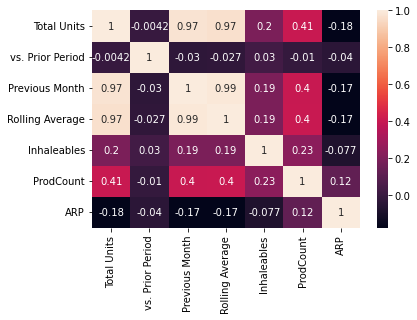

In [378]:
corrMatrix = df.corr()
sns.heatmap(corrMatrix, annot=True)
plt.show()

In [379]:
df.drop(columns = ['Previous Month','Rolling Average'],inplace =True)

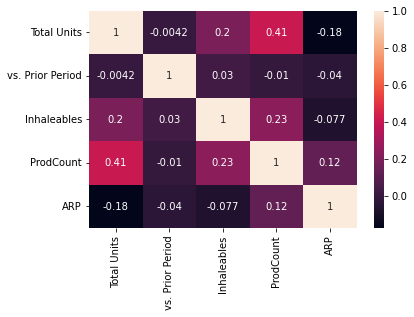

In [293]:
corrMatrix = df.corr()
sns.heatmap(corrMatrix, annot=True)
plt.show()

In [294]:
df.head()

,Brands,Months,Total Units,vs. Prior Period,Inhaleables,ProdCount,ARP
4,101 Cannabis Co.,2020-04-01,712.4981,-0.244750,1,77,32.934344
5,101 Cannabis Co.,2020-05-01,619.8410,-0.130045,1,77,34.441725
6,101 Cannabis Co.,2020-06-01,426.1504,-0.312484,1,77,33.114497
7,101 Cannabis Co.,2020-07-01,589.7193,0.383829,1,77,32.131407
8,101 Cannabis Co.,2020-08-01,1018.5700,0.727218,1,77,32.146382


Hypothesis testing for the features

In [295]:
df2= pd.get_dummies(df, columns=['Inhaleables'], drop_first=True)

In [296]:
df2= pd.get_dummies(df, columns=['Months','Brands'], drop_first=True)

In [297]:
df2.head()

,Total Units,vs. Prior Period,Inhaleables,ProdCount,ARP,Months_2018-12-01 00:00:00,Months_2019-01-01 00:00:00,Months_2019-02-01 00:00:00,Months_2019-03-01 00:00:00,Months_2019-04-01 00:00:00,...,Brands_Zarabanda,Brands_ZaxWax,Brands_Zeki,Brands_Zen Brands,Brands_Zendo Edibles,Brands_Zig Zag,Brands_Zips Weed Co.,Brands_Zkittlez,Brands_Zoma,Brands_Zuma Topicals
4,712.4981,-0.244750,1,77,32.934344,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,619.8410,-0.130045,1,77,34.441725,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,426.1504,-0.312484,1,77,33.114497,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,589.7193,0.383829,1,77,32.131407,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,1018.5700,0.727218,1,77,32.146382,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [299]:
df3=df.drop(columns=['Inhaleables','Months','Brands'])

In [306]:
scaler = preprocessing.MinMaxScaler()
names = df3.columns
d = scaler.fit_transform(df3)
scaled_df = pd.DataFrame(d, columns=names)
scaled_df.head()

,Total Units,vs. Prior Period,ProdCount,ARP
0,0.000774,0.002995,0.008552,0.167747
1,0.000673,0.003450,0.008552,0.175660
2,0.000461,0.002726,0.008552,0.168693
3,0.000640,0.005491,0.008552,0.163532
4,0.001109,0.006855,0.008552,0.163611


In [307]:
x_train, x_test, y_train, y_test=train_test_split(scaled_df,target,test_size=0.2,random_state=42)

In [308]:
y=y_test
x=x_test
y=list(y)
x2 = sm.add_constant(x)
est = sm.OLS(y, x2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.146
Model:                            OLS   Adj. R-squared:                  0.145
Method:                 Least Squares   F-statistic:                     163.1
Date:                Sun, 13 Mar 2022   Prob (F-statistic):          4.55e-129
Time:                        15:14:48   Log-Likelihood:                -51786.
No. Observations:                3820   AIC:                         1.036e+05
Df Residuals:                    3815   BIC:                         1.036e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const             1.352e+05   5969.519  

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


At a significance level of 0.1 I found that one of the regression coefficients turned out to be higher than this therefore I removed it from the dataset

In [310]:
df.drop(columns=['vs. Prior Period'], inplace=True)

In [311]:
num_pipeline = Pipeline([
        ('std_scaler', StandardScaler()),
    ])


categorical_features = ['Brands','Months','Inhaleables']
numerical_features = [x for x in df.columns if x not in categorical_features]

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, numerical_features),
        ("cat", OneHotEncoder(handle_unknown='ignore'), categorical_features),
    ])

df_transformed = full_pipeline.fit_transform(df)

In [312]:
new_df=pd.DataFrame(df_transformed.toarray())
new_df.head()

,0,1,2,3,4,5,6,7,8,9,...,1259,1260,1261,1262,1263,1264,1265,1266,1267,1268
0,-0.406161,-0.259059,0.632170,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,-0.407481,-0.259059,0.723959,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,-0.410242,-0.259059,0.643140,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,-0.407910,-0.259059,0.583276,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,-0.401799,-0.259059,0.584188,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [313]:
features_train, features_test, target_train, target_test=train_test_split(new_df,target,test_size=0.2,random_state=42)

In [314]:
target_train

18     43724.40
11     13118.60
29     69509.90
10     72953.00
3      71135.80
        ...    
4       4992.46
11    882016.00
14     91136.90
11     40158.00
9      36171.40
Name: Total Sales ($), Length: 15280, dtype: float64

In [315]:
# train a linear regression model
lin_reg = LinearRegression()
lin_reg.fit(features_train, target_train)

# choose a few training examples and make predictions on them
features = features_train[:5]
targets = target_train[:5]
predictions = lin_reg.predict(features)

print("Predictions:", predictions)
print("Actual labels:", list(targets))

Predictions: [42528. 22688. 57664. 55648. 17920.]
Actual labels: [43724.4, 13118.6, 69509.9, 72953.0, 71135.8]


In [316]:
# train a linear regression model
lin_reg = LinearRegression()
lin_reg.fit(features_test, target_test)

# choose a few training examples and make predictions on them
features = features_test[:5]
targets = target_test[:5]
predictions = lin_reg.predict(features)

print("Predictions:", predictions)
print("Actual labels:", list(targets))

Predictions: [356520.  93224.  20336. 418592. 288840.]
Actual labels: [294703.0, 107248.0, 11815.5, 592861.0, 73897.5]


In [317]:
regression_results(targets,predictions)

explained_variance:  0.645
mean_squared_log_error:  0.466
r2:  0.6365
MAE:  94714.6
MSE:  16132115130.5
RMSE:  127012.2637


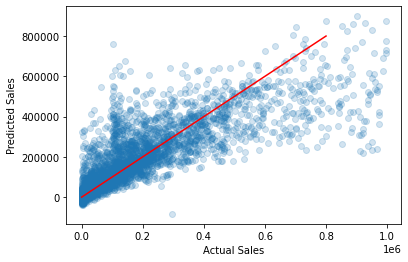

In [320]:
# We can also visualize our predicted values against the correct values. Ideally, our
# predictions should be very close to the correct value, i.e. the predictions should be
# close to the red line.

features = features_test
targets = target_test
predictions = lin_reg.predict(features)

plt.scatter(target_test, predictions, alpha=0.2)
plt.plot([0,800000],[0,800000], 'r') 
plt.xlabel('Actual Sales')
plt.ylabel('Predicted Sales')
plt.show()

# Implement Principle Component Analysis (PCA)

In [321]:
from sklearn.decomposition import PCA


In [322]:
pca = PCA(n_components = 2)
 
features_train2 = pca.fit_transform(features_train)
features_test2 = pca.transform(features_test)
 
explained_variance = pca.explained_variance_ratio_
explained_variance

array([0.26713271, 0.20091417])

In [323]:
lin_reg = LinearRegression()
lin_reg.fit(features_test2, target_test)

LinearRegression()

In [324]:
features = features_test2[:5]
targets = target_test[:5]
predictions = lin_reg.predict(features)

print("Predictions:", predictions)
print("Actual labels:", list(targets))

Predictions: [156271.88951328 155325.77015349 123749.4856307  191803.02908218
 142955.45796195]
Actual labels: [294703.0, 107248.0, 11815.5, 592861.0, 73897.5]


In [325]:
regression_results(targets,predictions)

explained_variance:  0.1874
mean_squared_log_error:  1.553
r2:  0.1005
MAE:  153711.759
MSE:  39924071813.4577
RMSE:  199810.0894


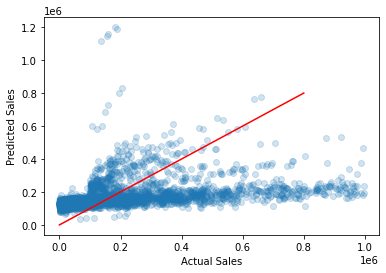

In [326]:
features = features_test2
targets = target_test
predictions = lin_reg.predict(features)

plt.scatter(target_test, predictions, alpha=0.2)
plt.plot([0,800000],[0,800000], 'r') 
plt.xlabel('Actual Sales')
plt.ylabel('Predicted Sales')
plt.show()

All of my regression results seemed to decrease and the model performed worse after conducting PCA

# Ensemble Method - Random Forest

In [327]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

In [328]:
forest = RandomForestRegressor(n_estimators=500, max_depth=5, min_samples_split=2, random_state=42).fit(features_train, target_train)

predictions = forest.predict(features_test)

In [329]:
regression_results(target_test, predictions)

explained_variance:  0.7121
mean_squared_log_error:  0.3705
r2:  0.712
MAE:  52515.2734
MSE:  11760795789.0494
RMSE:  108447.2028


In [330]:
forest = RandomForestRegressor(n_estimators=100, max_depth=10, min_samples_split=2, random_state=42).fit(features_train, target_train)

predictions = forest.predict(features_test)

In [331]:
features = features_test[:5]
targets = target_test[:5]
predictions = forest.predict(features)

print("Predictions:", predictions)
print("Actual labels:", list(targets))

Predictions: [296432.03865944 108574.39540003  11659.59285072 561668.12335141
  75336.1897637 ]
Actual labels: [294703.0, 107248.0, 11815.5, 592861.0, 73897.5]


In [332]:
features = features_test
targets = target_test
predictions = forest.predict(features)

In [333]:
regression_results(target_test, predictions)

explained_variance:  0.9142
mean_squared_log_error:  0.0412
r2:  0.9142
MAE:  16725.3946
MSE:  3505153901.5021
RMSE:  59204.3402


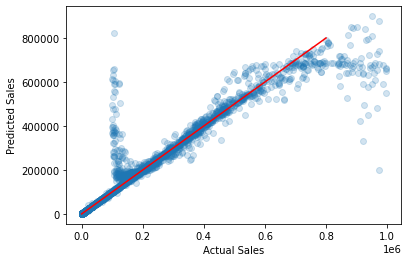

In [334]:
plt.scatter(target_test, predictions, alpha=0.2)
plt.plot([0,800000],[0,800000], 'r') 
plt.xlabel('Actual Sales')
plt.ylabel('Predicted Sales')
plt.show()

The random forest model becomes much better at predicting the Sales of Cannabis Stores. R^2 goes up to 0.91 and mean squared log error drops dramatically 

# Cross Validation

In [335]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

In [336]:
new_df

,0,1,2,3,4,5,6,7,8,9,...,1259,1260,1261,1262,1263,1264,1265,1266,1267,1268
0,-0.406161,-0.259059,0.632170,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,-0.407481,-0.259059,0.723959,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,-0.410242,-0.259059,0.643140,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,-0.407910,-0.259059,0.583276,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,-0.401799,-0.259059,0.584188,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19095,-0.275752,-0.404110,-0.710500,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
19096,-0.371118,-0.404110,-0.809331,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
19097,-0.386622,-0.404110,-1.094715,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
19098,-0.400342,-0.404110,-1.061277,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [337]:
target

4     23465.60
5     21348.30
6     14111.70
7     18948.50
8     32743.40
       ...    
4    107356.00
5     29372.20
6      9532.21
7      5743.27
3      5008.72
Name: Total Sales ($), Length: 19100, dtype: float64

In [338]:
folds = KFold(n_splits = 5, shuffle = True, random_state = 100)
scores = cross_val_score(lin_reg, features_test, target_test, scoring='r2', cv=folds)
scores  

array([-1.55728597e+20, -5.39342426e+22, -4.17085597e+21, -5.57090430e+20,
       -1.76298786e+22])

In [339]:
rf_cv_score=cross_val_score(forest, features_test,target_test,cv=5)
print(rf_cv_score)

[0.83647628 0.82861509 0.82995555 0.84799632 0.83193219]


# Grid Search + Cross Validation (random forest)

In [340]:
from sklearn.model_selection import GridSearchCV

In [268]:
n_estimators = [i for i in range(5,100,35)]
max_features = ['auto', 'sqrt']
max_depth = [i for i in range(2,100,20)]
min_samples_split = [i for i in range(1,10,3)]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
              }

folds = KFold(n_splits = 5, shuffle = True, random_state = 42)

In [269]:
tune_model = GridSearchCV(estimator = forest, 
                          param_grid = random_grid, 
                          cv = folds, 
                          verbose=1, 
                         )
tune_model.fit(features_train, target_train)
print(tune_model.best_params_)

best_grid = tune_model.best_estimator_
preds = best_grid.predict(features_test)

regression_results(target_test, preds)

Fitting 5 folds for each of 90 candidates, totalling 450 fits


/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 779, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 779, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 779, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 779, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 779, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 779, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 779, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 779, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 779, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 779, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 779, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 779, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 779, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 779, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 779, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 779, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 779, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 779, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 779, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 779, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 779, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)

{'max_depth': 42, 'max_features': 'auto', 'min_samples_split': 4, 'n_estimators': 75}
explained_variance:  0.9438
mean_squared_log_error:  0.0269
r2:  0.9437
MAE:  10042.7755
MSE:  2297724162.4481
RMSE:  47934.5821


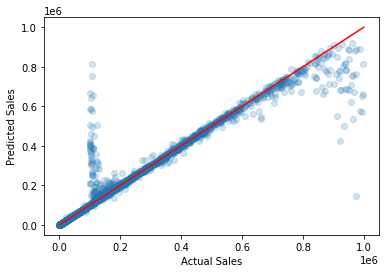

In [356]:
plt.scatter(target_test, preds, alpha=0.2)
plt.plot([0,1000000],[0,1000000], 'r') 
plt.xlabel('Actual Sales')
plt.ylabel('Predicted Sales')
plt.show()

# Own Custom Model Experimentation - Bagging 

In [341]:
from sklearn.ensemble import BaggingRegressor

In [347]:
bagger=BaggingRegressor(best_grid,n_estimators=10, bootstrap_features=True,random_state=42).fit(features_train, target_train)

In [348]:
predictions = bagger.predict(features_test)

In [349]:
regression_results(target_test, predictions)

explained_variance:  0.7591
mean_squared_log_error:  1.3561
r2:  0.7591
MAE:  59112.3149
MSE:  9837992748.3372
RMSE:  99186.6561


In [351]:
bagger=BaggingRegressor(best_grid,n_estimators=10, bootstrap_features=False,random_state=42).fit(features_train, target_train)
predictions = bagger.predict(features_test)
regression_results(target_test, predictions)

explained_variance:  0.9393
mean_squared_log_error:  0.0301
r2:  0.9393
MAE:  11705.3104
MSE:  2479314087.2865
RMSE:  49792.7112
